<a href="https://colab.research.google.com/github/afrojaakter/Surrogate-Based-Optimization/blob/main/GP_ActiveLearning_E_Improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Gaussian Process Model with Active Learning and Expected Improvement Function

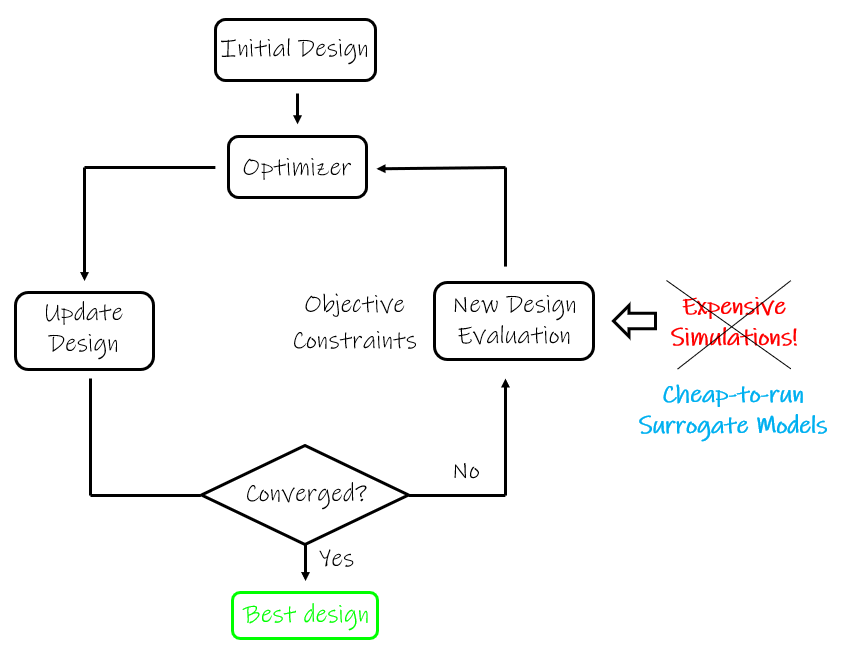

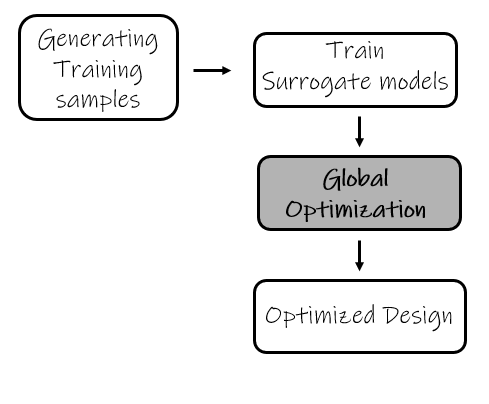

Here I will use a surrogate optimization approack to locate the global minimum of test function. For case study, a Gaussian Process (GP) model is adopted as the surrogate model.

Reference: [An Introduction To Surrogate Optimization](https://towardsdatascience.com/an-introduction-to-surrogate-optimization-intuition-illustration-case-study-and-the-code-5d9364aed51b)

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
from scipy.integrate import quad
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import os
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

np.set_printoptions(precision =2, suppress = True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


***Test Function:*** Assume the true underlying test function is:
$$F(x) = (6x - 2)^2sin(12x-4), x \in [0, 1]$$
So, we can visually identify the global minimum of this test function by plotting it out


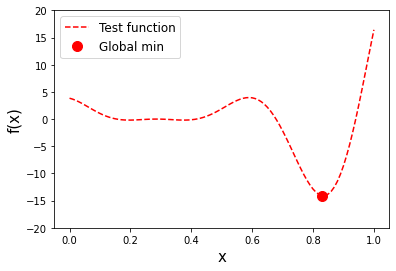

Global minimum at x = 0.8300000000000001


In [2]:
# Test function values
X_test = np.arange(0, 1.01, 0.01)
y_test = (X_test*7-2)**2*np.sin(X_test*12-5)#(6*X_test - 2)**2*np.sin(12*X_test - 4)

# Plot test function
plt.plot(X_test, y_test, 'r--', label = 'Test function')
plt.xlabel('x', fontsize= 15)
plt.ylabel('f(x)', fontsize= 15)
plt.ylim([-20, 20])

# Plot global minimum
min_index = np.argmin(y_test)
plt.plot(X_test[min_index], y_test[min_index], 'ro', label = 'Global min', markersize = 10)
plt.legend(loc='upper left', prop={'size': 12})
plt.show()

print("Global minimum at x = {}".format(X_test[min_index]))

###GP-based Surrogate Optimization
In practice, $f(x)$ is unknown and even if possible to evaluate, the process is complicated and time consuming. Therefor, to reflict the real world scenario we will assume:
- $f(x)$ as a black-box function
- limit the number of $f(x)$ evaluations

In order to search for global minimum, we will use surrogate optimization technique.

Here, I will use GP model as the surrogate model. The prediction $y$ of GP model at a sample location $x$ follows a normal distribution, i.e., $y \sim N(\mu(x), \sigma(x)^2$


In [3]:
# Initial training data
noise_level = 0.1
X_train = np.array([[0,0.1,0.2,0.4,0.6,1]]).T
y_train = (7*X_train - 2)**2*np.sin(12*X_train - 5) + np.random.randn()*noise_level


In [4]:
# Train initial Gaussian Process (GP) model
kernel = gp.kernels.ConstantKernel(1.0,(1e-1,1e3))*gp.kernels.RBF(1.0,(1e-3,1e3))
model = gp.GaussianProcessRegressor(kernel=kernel, 
                                    optimizer='fmin_l_bfgs_b',
                                    n_restarts_optimizer= 30, 
                                    alpha = 1e-10,
                                    normalize_y = True)
model.fit(X_train, y_train)

# Prediction
y_pred, pred_std = model.predict(X_test.reshape((-1,1)), return_std=True)

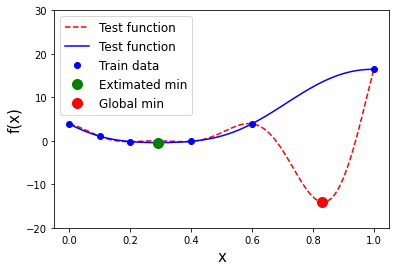

Estimated Global minimum at x = 0.29


In [5]:

# Check GP prediction accuracy
plt.plot(X_test, y_test, 'r--', label = 'Test function')
plt.plot(X_test, y_pred, 'b-', label = 'Test function')
plt.plot(X_train, y_train, 'bo', label = 'Train data')

# 1-Find the current minimum
Predicted_min_index = np.argmin(y_pred)
plt.plot(X_test[Predicted_min_index], y_pred[Predicted_min_index], 'go', label = 'Extimated min', markersize = 10)
plt.plot(X_test[min_index], y_test[min_index], 'ro', label = 'Global min', markersize = 10)
plt.legend(loc='upper left', prop={'size': 12})
plt.xlabel('x', fontsize= 15)
plt.ylabel('f(x)', fontsize= 15)
plt.ylim([-20, 30])
plt.show()

print("Estimated Global minimum at x = {}".format(X_test[Predicted_min_index]))

which is far away from the location of global mininum $0.6 \sim 1$. Which is a indication of model refinement.

### Active Learning
To improve the GP model accuracy in capturing the global minimum, we need more data. We will use active learning technique to iteratively refine the model.

i.e., at each learning iteration, we will look for a sample location $x^{\ast}$ such that it maximizes a pre-defined learning function. Subsequently, we calculate the true objective value $f(x^{\ast})$ and enrich the current training dataset by adding $[x^{\ast}, f(x^{\ast})]$ as additional training data. Then we update the GP model using the enriched dataset, thus completing one learning iteration.

###Expected Improvement Function
At any location $x$, the GP prediction $y(x)$ follows a normal distribution, i.e., $y(x) \sim  \mathcal{N}(\mu(x), \sigma^2(x))$. If $y(x)$ is smaller than the current minimum $y_{min}$, then there is a potential for improvement, as highlighted by the shaded area below.


Naturally, we would be interested in identifying the location $x$ in the parameter space such that the associated improvement potential is the highest. It then makes intuitive sense to refine the GP model at location $x$, which would bring us one step closer to the true global minimum.

Quantitatively, we can define improvement $I$ in the following way:

$$
  I(x) =
    \begin{cases}
      y_{min}-y(x) &amp; \text{if} \; y(x)&lt;y_{min}\\
      0 &amp; \text{if} \ y(x) \geq y_{min}
    \end{cases} 
$$
Furthermore, we could calculate the expected value of $I(x)$ and use it to measure the improvement potential:

$$
E[I(x)] = (y_{min}-\mu(x))\Phi \left (\frac{y_{min}-\mu(x)}{\sigma(x)} \right ) + \sigma(x)\phi \left (\frac{y_{min}-\mu(x)}{\sigma(x)} \right )
$$
where $\Phi(.)$ and $\phi(.)$ are the cumulative distribution function and probability density function of the normal distribution. The above equation for $E[I(x)]$ is the expected improvement function at location $x$.

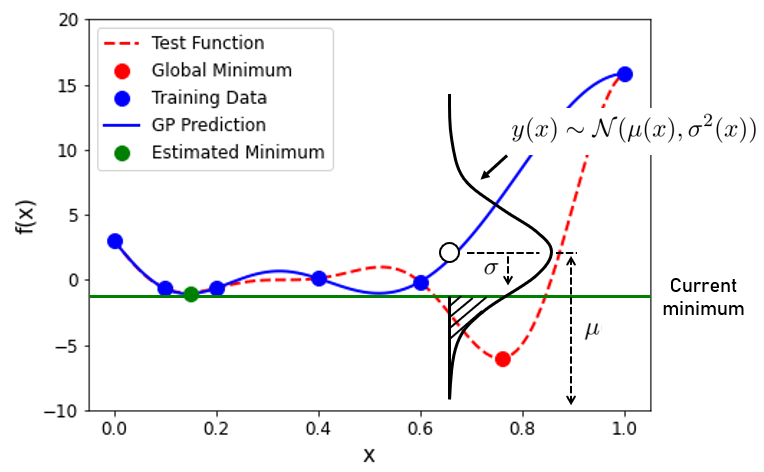

 #### Surrogate Optimization in Action
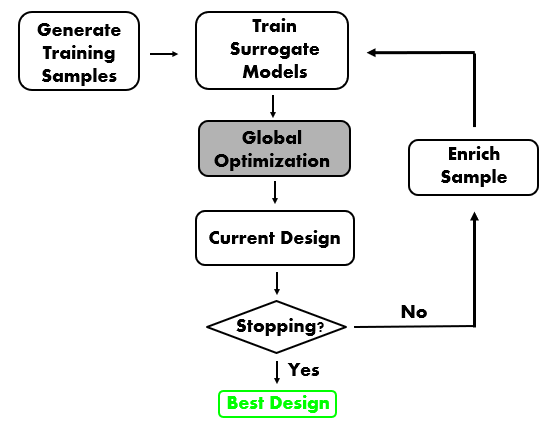

#### First iteration


In [6]:
# Surrogate optimization based on Expected Improvement

# 2-Calculate expected improvement 
current_location = X_test[Predicted_min_index]
current_objective = y_pred[Predicted_min_index]
#Calculate Expected Imporvement
pred_std = pred_std.reshape(pred_std.shape[0], 1)
EI = (current_objective - y_pred) * st.norm.cdf((current_objective - y_pred)/pred_std) \
    + pred_std * st.norm.pdf((current_objective - y_pred)/pred_std)

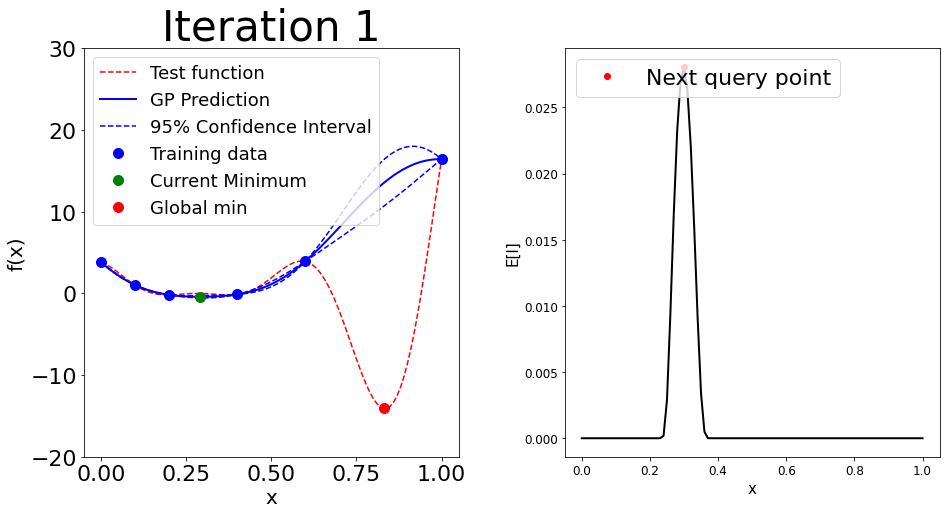

In [7]:
# 3-Post-processing
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 35})
fig, axs = plt.subplots(1,2,figsize=(14,8))
axs[0].plot(X_test, y_test, 'r--', label = 'Test function')
axs[0].plot(X_test,y_pred,'b-',linewidth=2,label='GP Prediction')
axs[0].plot(X_test,y_pred+1.95*pred_std,'b--',linewidth=1.5)
axs[0].plot(X_test,y_pred-1.95*pred_std,'b--',linewidth=1.5,
            label='95% Confidence Interval')
axs[0].plot(X_train,y_train,'bo',markerfacecolor='b',
            markersize=10,label='Training data')
axs[0].plot(current_location,current_objective,'go',
        markerfacecolor='g',markersize=10,label='Current Minimum');
axs[0].plot(X_test[min_index], y_test[min_index], 'ro', 
         label = 'Global min', markersize = 10)
axs[0].legend(loc="upper left",prop={'size': 18})
axs[0].tick_params(axis='both', which='major', labelsize=22)
axs[0].set_xlabel('x', fontsize=20)
axs[0].set_ylabel('f(x)', fontsize=20)

axs[0].set_ylim([-20,30]);


axs[1].plot(X_test,EI,'k-',linewidth=2)
axs[1].plot(X_test[np.argmax(EI)],np.max(EI), 'ro', label = 'Next query point')
axs[1].set_xlabel('x', fontsize=20)
axs[1].set_ylabel('E[I]', fontsize=20)
axs[1].legend(loc="upper left",prop={'size': 22})
axs[1].set_xlabel('x', fontsize=15)
axs[1].set_ylabel('E[I]', fontsize=15)
axs[0].set_title('Iteration 1')
axs[1].tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout();
fig.savefig('First_iteration.png')


The figure on the left shows the initial GP model trained from 6 initial training samples. 95% confidence intervals (μ±1.96σ) of the GP predictions are also plotted.

On the right, we can see the distribution of $E[I(x)]$ values at different x locations. A prominent spike is observed at $x=0.52$, indicating a high potential for improvement at that location. This makes sense as the GP prediction $μ(x)$ at $x=0.52$ is fairly close to the current minimum, and the associated prediction standard deviation $σ(x)$ is rather large. Although $σ(x)$ is also large in the region of $x=0.6\sim1.0, μ(x)$ is way much larger than the current minimum, therefore not much hope for finding improvements.

So, in this first iteration, we pick $x^\ast=0.52$ as the next sample and calculate $f(x^\ast)=0.98$.

#### Further iterations
First, we define a EI_Learning function to perform any necessary calculations.

In [8]:
# Expected Improvement-based active learning function
def EI_learning(candidates, y_pred, pred_std):
    """Active learning function based on expected improvement
       
       This function selects a new sample from candidate pool to 
       enrich the current training dataset.The sample gets selected
       if it has the maximum expected improvement value.
       
       Input: 
       - candidates: pool of candidates to select sample from
       - y_pred: GP predictions on candidate samples
       - pred_std: Standard deviation of the GP predictions on candidate samples
       
       Output:
       - new_sample: the selected sample with the maximum expected improvement value
       - EI: EI values of the candidate samples
    """
    
    # 1-Find the current minimum
    current_objective = y_pred[np.argmin(y_pred)]
    
    # 2-Calculate the EI values of the candidate samples
    pred_std = pred_std.reshape(pred_std.shape[0], 1)
    EI = (current_objective-y_pred)*st.norm.cdf((current_objective-y_pred)/pred_std) \
            +pred_std*st.norm.pdf((current_objective-y_pred)/pred_std)
    
    # 3-Select a new sample
    new_sample = candidates[np.argmax(EI)]
    
    return new_sample, EI

We pre-generated a large pool of candidate samples. For each iteration, we pick one sample from the candidate pool. This sample should yield the maximum expected improvement value among all the candidates.

In [9]:
# Surrogate optimization: iterations

# 0-Create candidate samples
candidates = np.arange(0, 1.01, 0.01)
iteration = 0

Then we can start iterating. The following two cells can be excuted multiple times to manually control the iteration flow. The first cell searches for the global optimum by gradually refining the GP model using expected improvement learning function. The second cell visually summarizes the results from the current iteration and add newly identified samples to the current training dataset.

()
Iteration 0:
the current minimum is -0.41032856970520015
located at 0.29
()
Iteration 1:
the current minimum is -0.18820612249119995
located at 0.22
()
Iteration 2:
the current minimum is -0.1864597337511773
located at 0.37
()
Iteration 3:
the current minimum is -10.396134319145494
located at 0.78


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


()
Iteration 4:
the current minimum is -14.164701418762167
located at 0.84


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


()
Iteration 5:
the current minimum is -14.070909798323811
located at 0.8300000000000001


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


()
Iteration 6:
the current minimum is -14.073369039950709
located at 0.8300000000000001


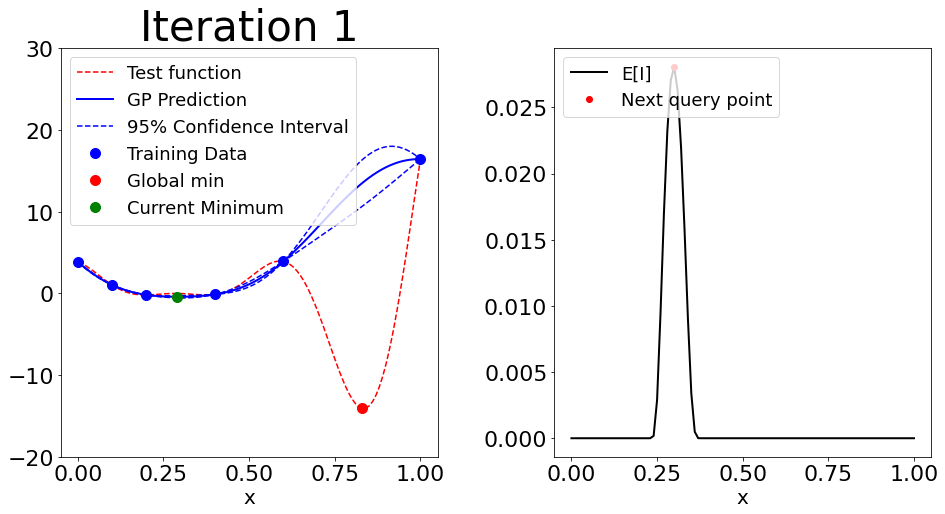

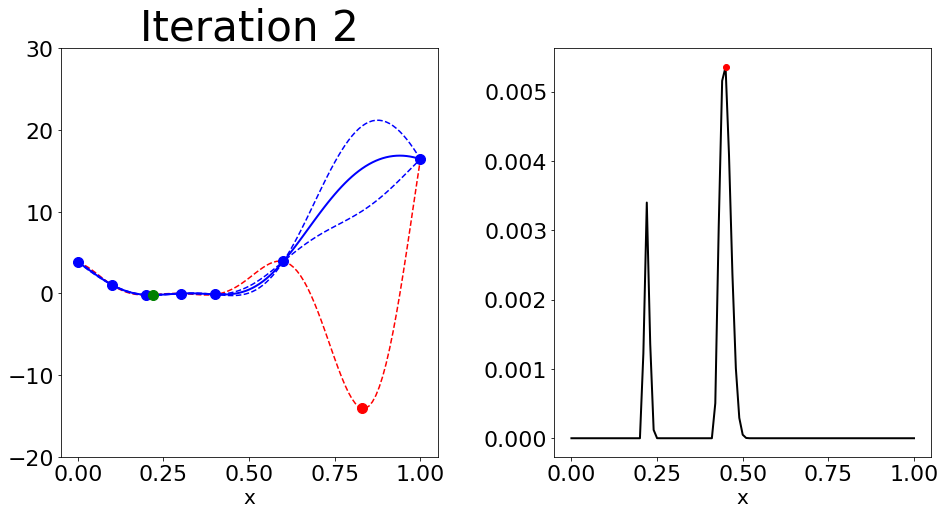

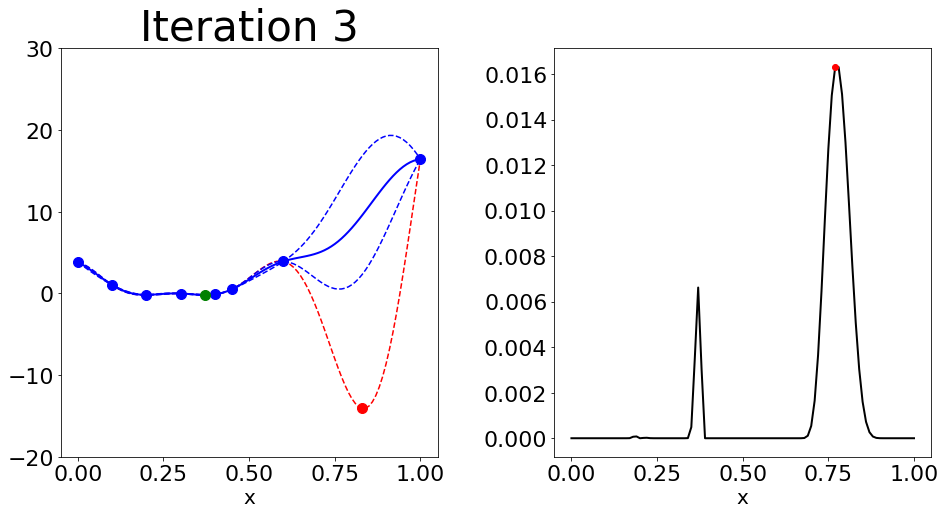

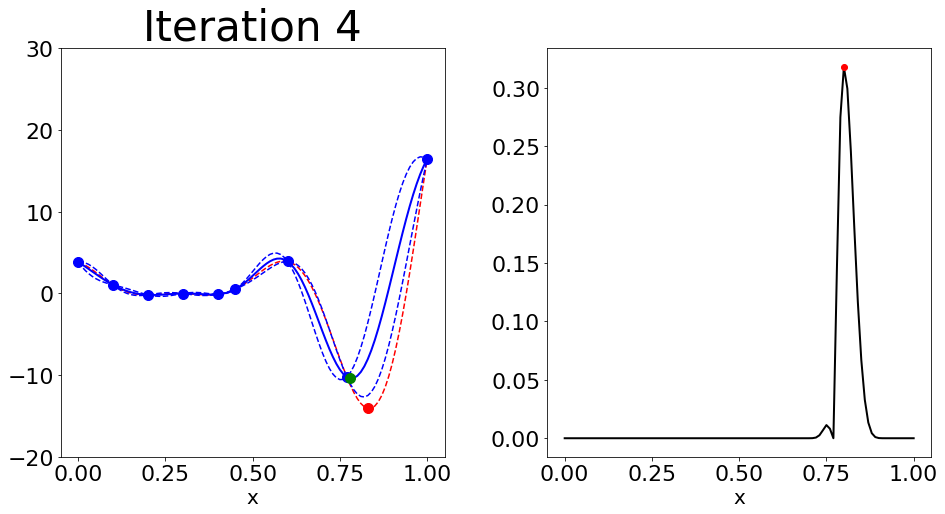

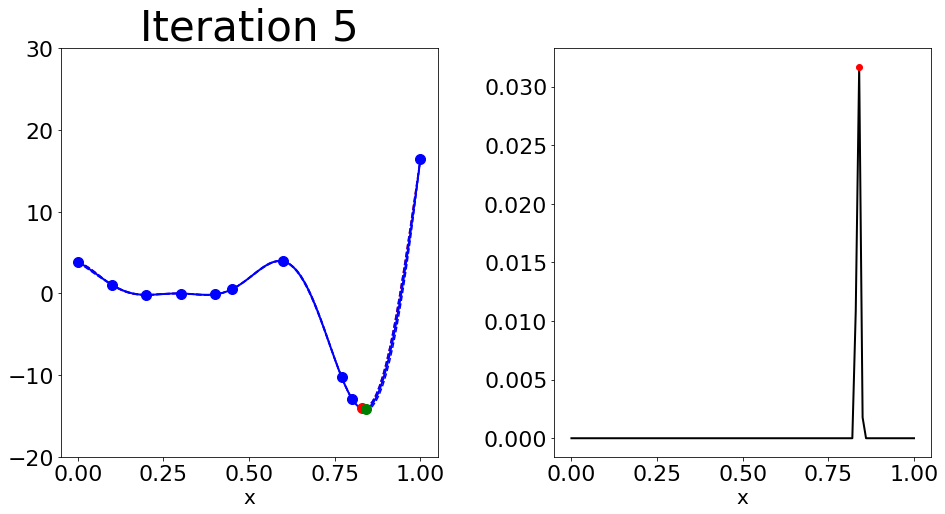

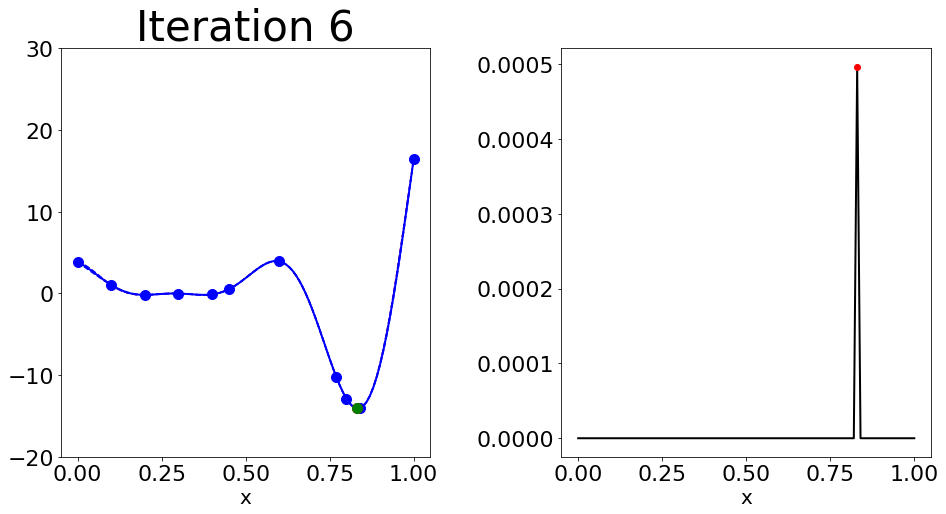

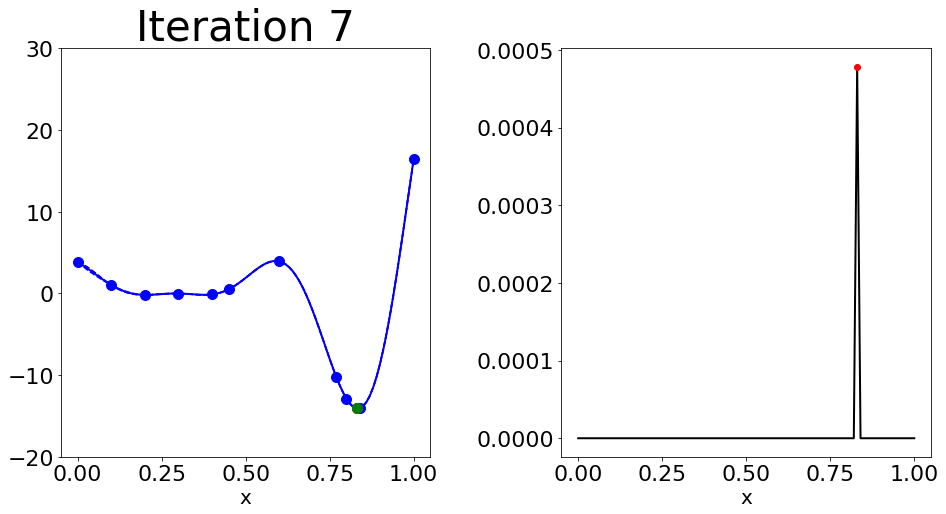

In [10]:
for i in range(7):
  # 1-GP model training and predicting
  model.fit(X_train, y_train)
  y_pred, pred_std = model.predict(candidates.reshape((-1, 1)), return_std=True)
  y_test_pred, pred_test_std = model.predict(X_test.reshape((-1, 1)), return_std=True)
  pred_test_std = pred_test_std.reshape(pred_test_std.shape[0], 1)

  # 2-Calculate the current minimum
  current_min = y_pred[np.argmin(y_pred),0]
  location = candidates[np.argmin(y_pred)]

  # 3-Select next sample
  pred_std += 1e-8        # To prevent zero standard deviation value
  new_sample, EI = EI_learning(candidates, y_pred, pred_std)
  print(new_sample.shape)

  # 4-Calculate the true label of the new sample
  y_sample = (new_sample*7-2)**2*np.sin(new_sample*12-5)#(new_sample*6-2)**2*np.sin(new_sample*12-4)

  # 5-Display iteration info
  summary = 'Iteration summary:'
  iter_number = 'Current iteration: {}'.format(str(iteration))

  Iteration_summary = 'Iteration {}:'.format(str(iteration)) \
                      + os.linesep \
                      + 'the current minimum is {}'.format(str(current_min)) \
                      + os.linesep \
                      + 'located at {}'.format(str(location))

  print(Iteration_summary)

  # 6-Iteration assessment
  fig, axs = plt.subplots(1,2,figsize=(14,8))
  axs[0].plot(X_test, y_test, 'r--', label = 'Test function')
  axs[0].plot(X_test,y_test_pred,'b-',linewidth=2,label='GP Prediction')
  axs[0].plot(X_test,y_test_pred+1.95*pred_test_std,'b--',linewidth=1.5)
  axs[0].plot(X_test,y_test_pred-1.95*pred_test_std,'b--',linewidth=1.5,label='95% Confidence Interval')
  axs[0].plot(X_train,y_train,'bo',markerfacecolor='b',markersize=10,label='Training Data')
  axs[0].plot(X_test[min_index], y_test[min_index], 'ro', 
         label = 'Global min', markersize = 10)
  axs[0].set_xlabel('x', fontsize=20)
  axs[0].set_title('Iteration %i'%(i+1))
  axs[0].plot(location,current_min,'go',
          markerfacecolor='g',markersize=10,label='Current Minimum');
  if i == 0:
    axs[0].legend(loc="upper left",prop={'size': 18})
  axs[0].tick_params(axis='both', which='major', labelsize=22)
  axs[0].set_ylim([-20,30]);
  

  axs[1].plot(X_test,EI,'k-',linewidth=2, label = 'E[I]')
  axs[1].plot(X_test[np.argmax(EI)],np.max(EI), 'ro', label = 'Next query point')
  axs[1].set_xlabel('x', fontsize=20)
  if i == 0:
    axs[1].legend(loc="upper left",prop={'size': 18})
  axs[1].tick_params(axis='both', which='major', labelsize=22)
  fig.tight_layout();

  # 7-Enrich training dataset
  X_train = np.vstack((X_train,new_sample))
  y_train = np.vstack((y_train,y_sample))
  iteration += 1


After 4 iterations, we can see that the current GP model makes high-confident predictions almost everywhere. Meanwhile, the maximum $E[I(x)]$ value has dropped to the order of $10^{-5}$, indicating that we've identified the global minimum. 

We do know its true global minimum for this test function, which exactly locates at $x^{\ast}=0.76$. Therefore,the GP-based surrogate optimization algorithm has successfully identified the global minimum.